<a href="https://colab.research.google.com/github/Canihelpme/DeepLearning_finance/blob/main/Various_model_to_predict_Kospi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
from pathlib import Path

folder = ""
project_dir = ""

base_path = Path("/content/drive/My Drive/")
project_path = base_path / folder / project_dir
os.chdir(project_path)
for x in list(project_path.glob("*")):
    if x.is_dir():
        dir_name = str(x.relative_to(project_path))
        os.rename(dir_name, dir_name.split(" ", 1)[0])
print(f"현재 디렉토리 위치: {os.getcwd()}")

현재 디렉토리 위치: /content/drive/My Drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda, Input, RepeatVector, TimeDistributed, Flatten, Dropout, MaxPooling1D, Activation, LeakyReLU, PReLU
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import IPython
import IPython.display

%matplotlib inline
warnings.filterwarnings('ignore')

In [ ]:
filename = '/content/drive/MyDrive/Financial_data/Data/train/kospi_train_data.csv'
data = pd.read_csv(filename, sep=",",encoding='UTF-8')
data.head()

,Date,End,Open,High,Low,Amount,Val
0,2020년 02월 21일,"2,162.84","2,165.65","2,184.43","2,160.28",635.47M,-1.49%
1,2020년 02월 20일,"2,195.50","2,223.55","2,228.18","2,186.72",709.56M,-0.67%
2,2020년 02월 19일,"2,210.34","2,222.51","2,226.00","2,191.20",591.16M,0.07%
3,2020년 02월 18일,"2,208.88","2,225.98","2,232.93","2,205.21",470.42M,-1.48%
4,2020년 02월 17일,"2,242.17","2,243.07","2,250.05","2,230.26",458.25M,-0.06%


In [ ]:
date_index = data
date_index = date_index.copy()

In [ ]:
date_index['Date'] = date_index.Date.apply(str).str.replace("년","").str.replace("월","").str.replace("일","")
date_index['Date'] = date_index.Date.str.replace(" ","")

date_index['Amount'] = date_index.Amount.apply(str).str.replace("B", "0000000").str.replace("M","0000").str.replace("K","0").str.replace(".","")
date_index['Amount'] = date_index.Amount.astype(int)
date_index['Val'] = date_index.Val.apply(str).str.replace("%", "")
date_index['Val'] = date_index.Val.astype(float)
date_index['End'] = date_index.End.apply(str).str.replace(",","").astype(float)
date_index['Open'] = date_index.Open.apply(str).str.replace(",","").astype(float)
date_index['High'] = date_index.High.apply(str).str.replace(",","").astype(float)
date_index['Low'] = date_index.Low.apply(str).str.replace(",","").astype(float)

date_index = date_index.loc[::-1].reset_index(drop=True)
date_time = pd.to_datetime(date_index.pop('Date'))
date_index.tail()


,End,Open,High,Low,Amount,Val
10383,2242.17,2243.07,2250.05,2230.26,458250000,-0.06
10384,2208.88,2225.98,2232.93,2205.21,470420000,-1.48
10385,2210.34,2222.51,2226.00,2191.20,591160000,0.07
10386,2195.50,2223.55,2228.18,2186.72,709560000,-0.67
10387,2162.84,2165.65,2184.43,2160.28,635470000,-1.49


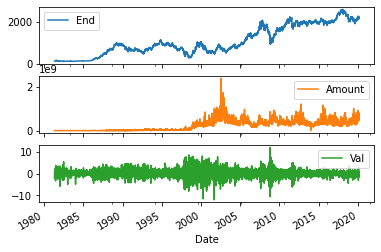

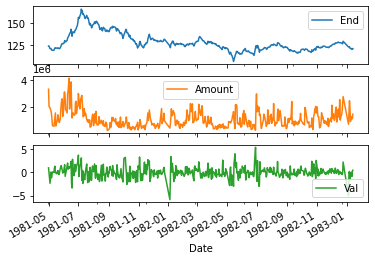

In [ ]:
plot_cols = ['End', 'Amount', 'Val']
plot_features = date_index[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)
#전체적인 데이터 출력
plot_features = date_index[plot_cols][:500]
plot_features.index = date_time[:500]
_ = plot_features.plot(subplots=True)
#데이터의 일부분만 출력하여 데이터의 특성을 추출
#Val, Amount의 경우 가끔 Shooting이 일어나는 값을 제외하고 일정한 범위내에 존재 함

In [ ]:
print(date_index)
print(date_index.shape)

           End     Open     High      Low     Amount   Val
0       123.60   123.60   123.60   123.60    3330000  0.98
1       123.50   123.50   123.50   123.50    2040000 -0.08
2       120.60   120.60   120.60   120.60    1930000 -2.35
3       120.70   120.70   120.70   120.70    1690000  0.08
4       119.30   119.30   119.30   119.30    1480000 -1.16
...        ...      ...      ...      ...        ...   ...
10383  2242.17  2243.07  2250.05  2230.26  458250000 -0.06
10384  2208.88  2225.98  2232.93  2205.21  470420000 -1.48
10385  2210.34  2222.51  2226.00  2191.20  591160000  0.07
10386  2195.50  2223.55  2228.18  2186.72  709560000 -0.67
10387  2162.84  2165.65  2184.43  2160.28  635470000 -1.49

[10388 rows x 6 columns]
(10388, 6)


In [ ]:
date_index.describe()

,End,Open,High,Low,Amount,Val
count,10388.000000,10388.000000,10388.000000,10388.000000,1.038800e+04,10388.000000
mean,1028.213099,1028.629756,1033.878016,1022.224383,2.175911e+08,0.038568
std,683.773007,684.222797,687.160231,679.985052,2.371764e+08,1.457766
min,105.990000,105.990000,105.990000,105.990000,1.660000e+05,-12.020000
25%,565.195000,565.175000,569.615000,558.530000,1.038000e+07,-0.622500
50%,847.615000,847.860000,853.475000,840.665000,1.765450e+08,0.030000
75%,1720.612500,1721.410000,1732.810000,1707.807500,3.758325e+08,0.712500
max,2598.190000,2590.410000,2607.100000,2587.550000,2.380000e+09,11.950000


In [ ]:
column_indices = {name: i for i, name in enumerate(date_index.columns)}

n = len(date_index)
train_df = date_index[0:int(n*0.7)]
val_df = date_index[int(n*0.7):int(n*0.9)]
test_df = date_index[int(n*0.9):]

num_features = date_index.shape[1]

In [ ]:
print(train_df)

          End     Open     High      Low     Amount   Val
0      123.60   123.60   123.60   123.60    3330000  0.98
1      123.50   123.50   123.50   123.50    2040000 -0.08
2      120.60   120.60   120.60   120.60    1930000 -2.35
3      120.70   120.70   120.70   120.70    1690000  0.08
4      119.30   119.30   119.30   119.30    1480000 -1.16
...       ...      ...      ...      ...        ...   ...
7266  1847.79  1841.56  1865.52  1836.93  534040000  0.51
7267  1861.01  1855.03  1863.01  1838.75  414380000  0.72
7268  1883.59  1870.35  1890.83  1865.79  430590000  1.21
7269  1894.53  1887.35  1895.98  1881.36  406270000  0.58
7270  1889.96  1880.71  1904.35  1875.43  473880000 -0.24

[7271 rows x 6 columns]


In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()

#Min-Max Scaling
train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [ ]:
print(train_df)
print(val_df)

           End      Open      High       Low    Amount       Val
0    -1.474065 -1.474174 -1.475191 -1.473744 -0.595490  0.601218
1    -1.474352 -1.474461 -1.475477 -1.474034 -0.601059 -0.084041
2    -1.482694 -1.482802 -1.483768 -1.482432 -0.601533 -1.551530
3    -1.482406 -1.482514 -1.483482 -1.482143 -0.602569  0.019394
4    -1.486433 -1.486541 -1.487484 -1.486197 -0.603476 -0.782230
...        ...       ...       ...       ...       ...       ...
7266  3.485398  3.466699  3.504494  3.488076  1.695228  0.297377
7267  3.523424  3.505439  3.497318  3.493347  1.178736  0.433136
7268  3.588373  3.549499  3.576848  3.571655  1.248704  0.749906
7269  3.619841  3.598392  3.591571  3.616746  1.143730  0.342630
7270  3.606695  3.579295  3.615498  3.599573  1.435557 -0.187477

[7271 rows x 6 columns]
           End      Open      High       Low    Amount           Val
7271  3.663619  3.627842  3.666670  3.663748  1.313233  6.464709e-01
7272  3.816586  3.767300  3.782992  3.791057  1.580974  1

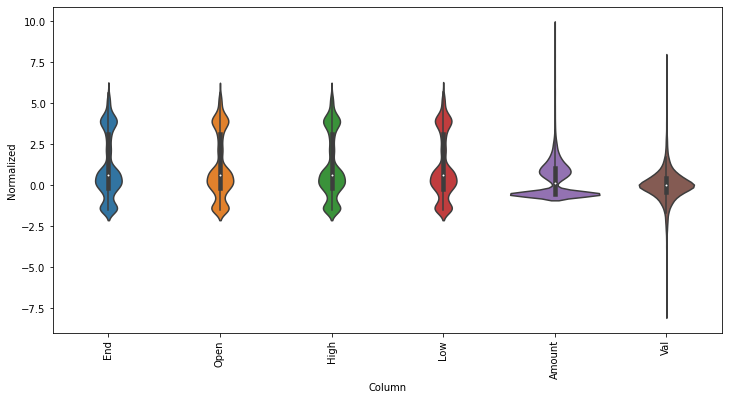

In [ ]:
df_std = (date_index - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(date_index.keys(), rotation=90)

##Stacked Autoencoder

In [ ]:
encoder = tf.keras.models.Sequential([
    tf.keras.layers.Dense(6, activation = 'relu', input_shape = (6,)),
    tf.keras.layers.Dense(4, activation = 'relu'),
    tf.keras.layers.Dense(2, activation = None)
])

decoder = tf.keras.models.Sequential([
    tf.keras.layers.Dense(4, activation = 'relu', input_shape = (2,)),
    tf.keras.layers.Dense(6, activation = 'relu'),
    tf.keras.layers.Dense(6, activation = None)
])

autoencoder = tf.keras.models.Sequential([encoder, decoder])

In [ ]:
autoencoder.compile(optimizer = tf.keras.optimizers.Adam(0.001),
                    loss = 'mean_squared_error',
                    metrics = ['mse', "accuracy"])

In [ ]:
training = autoencoder.fit(train_df,train_df, batch_size = 30, epochs = 50, validation_data=(val_df, val_df))

Epoch 1/50
243/243 [==============================] - 2s 3ms/step - loss: 0.9103 - mse: 0.9103 - accuracy: 0.1887 - val_loss: 4.7358 - val_mse: 4.7358 - val_accuracy: 0.3022
Epoch 2/50
243/243 [==============================] - 1s 2ms/step - loss: 0.4026 - mse: 0.4026 - accuracy: 0.2947 - val_loss: 1.0056 - val_mse: 1.0056 - val_accuracy: 0.3022
Epoch 3/50
243/243 [==============================] - 0s 2ms/step - loss: 0.3079 - mse: 0.3079 - accuracy: 0.3341 - val_loss: 0.6157 - val_mse: 0.6157 - val_accuracy: 0.2887
Epoch 4/50
243/243 [==============================] - 1s 2ms/step - loss: 0.2670 - mse: 0.2670 - accuracy: 0.3896 - val_loss: 0.6139 - val_mse: 0.6139 - val_accuracy: 0.3268
Epoch 5/50
243/243 [==============================] - 1s 2ms/step - loss: 0.2080 - mse: 0.2080 - accuracy: 0.4770 - val_loss: 0.4719 - val_mse: 0.4719 - val_accuracy: 0.3311
Epoch 6/50
243/243 [==============================] - 1s 2ms/step - loss: 0.1803 - mse: 0.1803 - accuracy: 0.4530 - val_loss: 0.34

In [ ]:
test_scores = autoencoder.evaluate(train_df, train_df, verbose = 2)
print('Test loss: {}'.format(test_scores[0]))
print('Mean Squared Error: {} %'.format(test_scores[1]*100))

228/228 - 0s - loss: 0.0500 - mse: 0.0500 - accuracy: 0.7038 - 225ms/epoch - 988us/step
Test loss: 0.050037749111652374
Mean Squared Error: 5.003774911165237 %


In [ ]:
print(training.history['val_loss'])


[4.735835075378418, 1.0056343078613281, 0.6156989336013794, 0.6139160394668579, 0.47194403409957886, 0.34056809544563293, 0.25943678617477417, 0.25179699063301086, 0.2541510760784149, 0.33022359013557434, 0.3498203456401825, 0.4420762360095978, 0.46112579107284546, 0.4627959430217743, 0.3936486840248108, 0.377097487449646, 0.3670516014099121, 0.34856101870536804, 0.3686039447784424, 0.3651217520236969, 0.3797881603240967, 0.3527581989765167, 0.3259936273097992, 0.3534208834171295, 0.3626078963279724, 0.34836000204086304, 0.35515832901000977, 0.3466138243675232, 0.3460555374622345, 0.334345281124115, 0.3204570412635803, 0.3211517333984375, 0.30842864513397217, 0.31831836700439453, 0.30948662757873535, 0.3038150668144226, 0.30162349343299866, 0.31749865412712097, 0.2894937992095947, 0.29787522554397583, 0.28304141759872437, 0.2868718206882477, 0.2858050763607025, 0.3210872709751129, 0.27949461340904236, 0.2937280237674713, 0.2848227620124817, 0.29002121090888977, 0.2857501208782196, 0.27

No handles with labels found to put in legend.


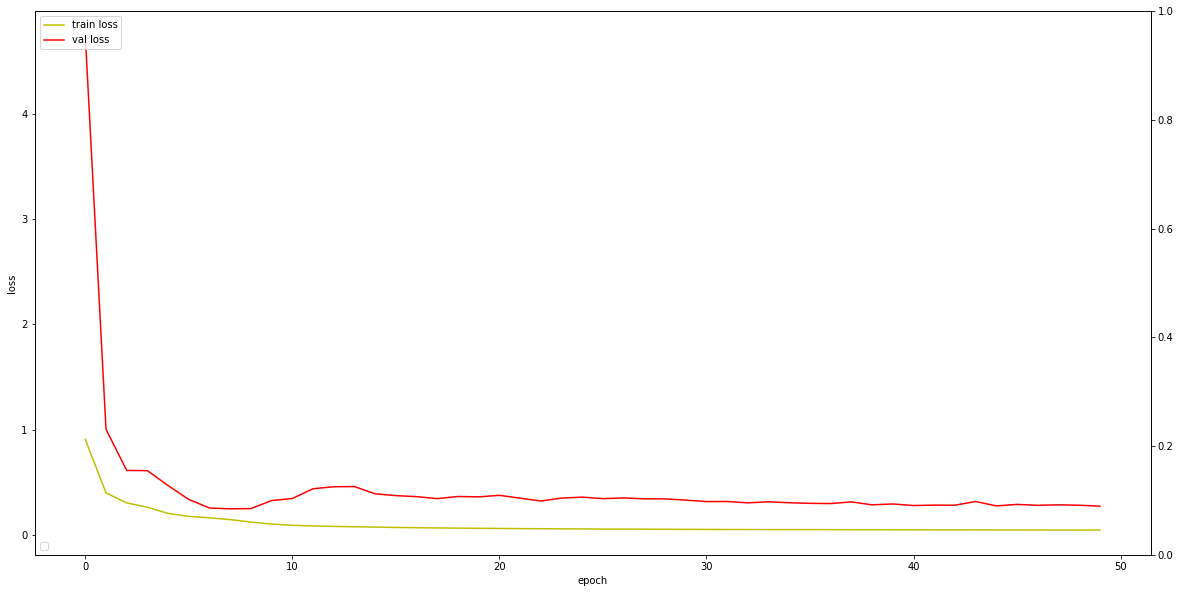

In [ ]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(training.history['loss'], 'y', label = 'train loss')
loss_ax.plot(training.history['val_loss'], 'r', label = 'val loss')

#acc_ax.plot(training.history['accuracy'], 'b', label = 'train accuracy')
#acc_ax.plot(training.history['val_accuracy'], 'g', label = 'valid accuracy')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
#acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

fig.set_size_inches(20,10)
plt.show()

In [ ]:
autoencoder_result = autoencoder.predict(train_df, verbose=0)
print(np.round(autoencoder_result,20))

[[-1.5138803  -1.5163238  -1.5200466  -1.5168933  -0.62689674  0.5479747 ]
 [-1.5255357  -1.5199339  -1.526423   -1.525461   -0.5659478  -0.10183491]
 [-1.5581267  -1.53526    -1.5476891  -1.5514505  -0.4355543  -1.4963738 ]
 ...
 [ 3.4534922   3.444675    3.4165456   3.446528    1.6437569  -0.14286442]
 [ 3.448058    3.4247055   3.4052532   3.43606     1.6031908  -0.15558167]
 [ 3.6398363   3.627839    3.5968628   3.6311917   1.8033277  -0.14781202]]


In [ ]:
autoencoder_result_df = pd.DataFrame(autoencoder_result)
autoencoder_result_df.columns = ["End", "Open", "High", "Low", "Amount", "Val"]
train_df = autoencoder_result_df
train_df

,End,Open,High,Low,Amount,Val
0,-1.513880,-1.516324,-1.520047,-1.516893,-0.626897,0.547975
1,-1.525536,-1.519934,-1.526423,-1.525461,-0.565948,-0.101835
2,-1.558127,-1.535260,-1.547689,-1.551450,-0.435554,-1.496374
3,-1.532135,-1.527754,-1.533826,-1.532555,-0.575630,-0.003410
4,-1.549412,-1.535601,-1.544918,-1.546225,-0.504388,-0.765014
...,...,...,...,...,...,...
7266,3.430398,3.501366,3.478138,3.443895,2.060450,-0.076991
7267,3.394774,3.368267,3.352017,3.381845,1.547585,-0.157740
7268,3.453492,3.444675,3.416546,3.446528,1.643757,-0.142864
7269,3.448058,3.424706,3.405253,3.436060,1.603191,-0.155582


In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [ ]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                   label_columns=['End'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['End']

In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)
print(w2.total_window_size)
print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}') #특성, 시간, 여러 예제

7
All shapes are: (batch, time, features)
Window shape: (3, 7, 6)
Inputs shape: (3, 6, 6)
labels shape: (3, 1, 1)


In [ ]:
w2.example = example_inputs, example_labels


In [ ]:
def plot(self, model=None, plot_col='End', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Day')

WindowGenerator.plot = plot

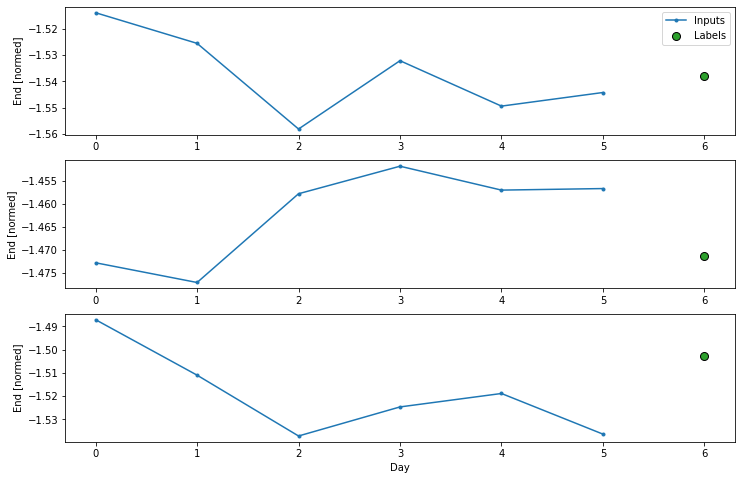

In [ ]:
w2.plot()


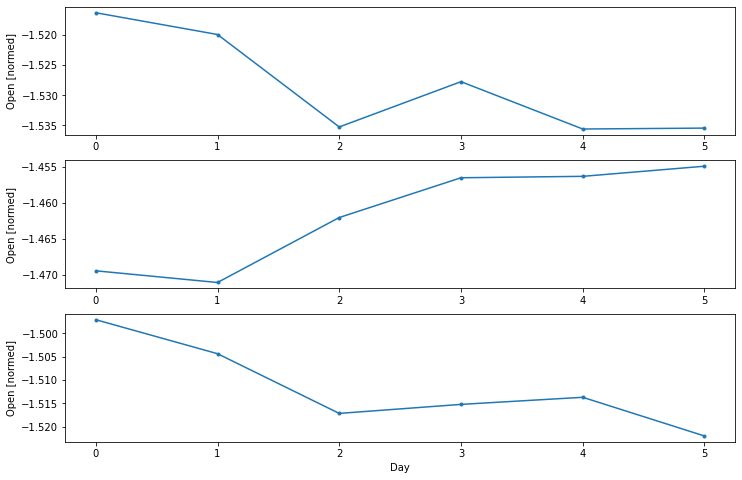

In [ ]:
w2.plot(plot_col='Open')

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [ ]:
# Each element is an (inputs, label) pair
w2.train.element_spec

(TensorSpec(shape=(None, 6, 6), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [ ]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 6)
Labels shape (batch, time, features): (32, 1, 1)


In [ ]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['End'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['End']

In [ ]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 6)
Labels shape (batch, time, features): (32, 1, 1)


In [ ]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [ ]:
baseline = Baseline(label_index=column_indices['End'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

65/65 [==============================] - 0s 4ms/step - loss: 0.0042 - mean_absolute_error: 0.0459


In [ ]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['End'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['End']

In [ ]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', baseline(single_step_window.example[0]).shape)

Input shape: (32, 1, 6)
Output shape: (32, 1, 1)


In [ ]:
print('Input shape:',wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 6)
Output shape: (32, 24, 1)


Single step

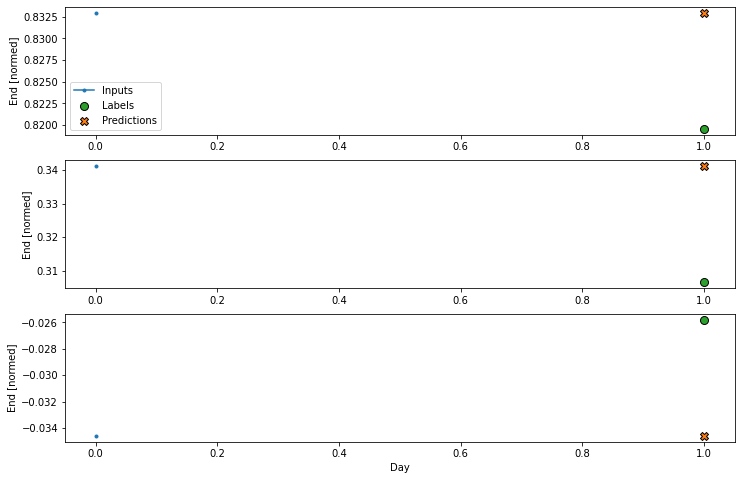

In [ ]:
single_step_window.plot(baseline)

Wide_window 예측(baseline)

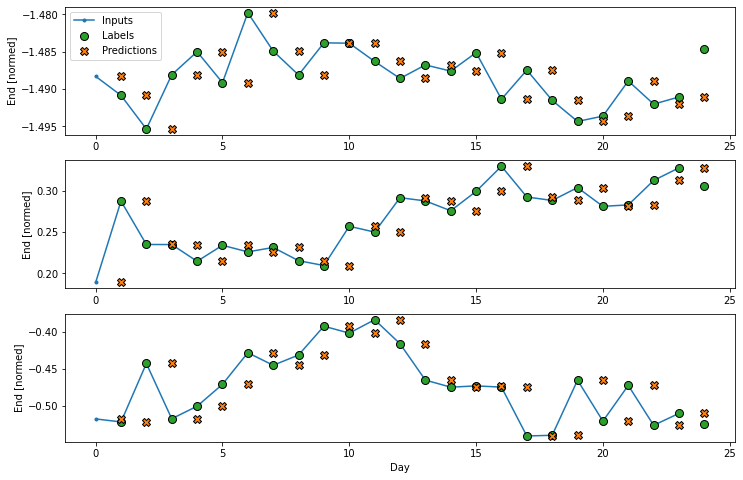

In [ ]:
wide_window.plot(baseline)

In [ ]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [ ]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 6)
Output shape: (32, 1, 1)


Model 제작 후 Single window로 예측

In [ ]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [ ]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
228/228 [==============================] - 2s 6ms/step - loss: 0.6133 - mean_absolute_error: 0.6356 - val_loss: 1.5017 - val_mean_absolute_error: 1.1666
Epoch 2/20
228/228 [==============================] - 1s 5ms/step - loss: 0.1110 - mean_absolute_error: 0.2528 - val_loss: 0.0911 - val_mean_absolute_error: 0.2763
Epoch 3/20
228/228 [==============================] - 1s 5ms/step - loss: 0.0355 - mean_absolute_error: 0.1178 - val_loss: 0.0078 - val_mean_absolute_error: 0.0701
Epoch 4/20
228/228 [==============================] - 2s 8ms/step - loss: 0.0242 - mean_absolute_error: 0.0860 - val_loss: 0.0045 - val_mean_absolute_error: 0.0487
Epoch 5/20
228/228 [==============================] - 2s 8ms/step - loss: 0.0227 - mean_absolute_error: 0.0814 - val_loss: 0.0053 - val_mean_absolute_error: 0.0558
Epoch 6/20
65/65 [==============================] - 0s 4ms/step - loss: 0.0057 - mean_absolute_error: 0.0594


Wide window로 예측

In [ ]:
history = compile_and_fit(linear, wide_window)

val_performance['Linear'] = linear.evaluate(wide_window.val)
performance['Linear'] = linear.evaluate(wide_window.test, verbose=0)

Epoch 1/20
227/227 [==============================] - 2s 6ms/step - loss: 0.0226 - mean_absolute_error: 0.0815 - val_loss: 0.0059 - val_mean_absolute_error: 0.0609
Epoch 2/20
227/227 [==============================] - 1s 5ms/step - loss: 0.0226 - mean_absolute_error: 0.0814 - val_loss: 0.0064 - val_mean_absolute_error: 0.0640
Epoch 3/20
227/227 [==============================] - 1s 5ms/step - loss: 0.0226 - mean_absolute_error: 0.0814 - val_loss: 0.0053 - val_mean_absolute_error: 0.0560
Epoch 4/20
227/227 [==============================] - 1s 5ms/step - loss: 0.0226 - mean_absolute_error: 0.0815 - val_loss: 0.0050 - val_mean_absolute_error: 0.0536
Epoch 5/20
227/227 [==============================] - 1s 5ms/step - loss: 0.0226 - mean_absolute_error: 0.0814 - val_loss: 0.0050 - val_mean_absolute_error: 0.0541
Epoch 6/20
227/227 [==============================] - 1s 5ms/step - loss: 0.0226 - mean_absolute_error: 0.0815 - val_loss: 0.0049 - val_mean_absolute_error: 0.0532
Epoch 7/20
227/2

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 6)
Output shape: (32, 24, 1)


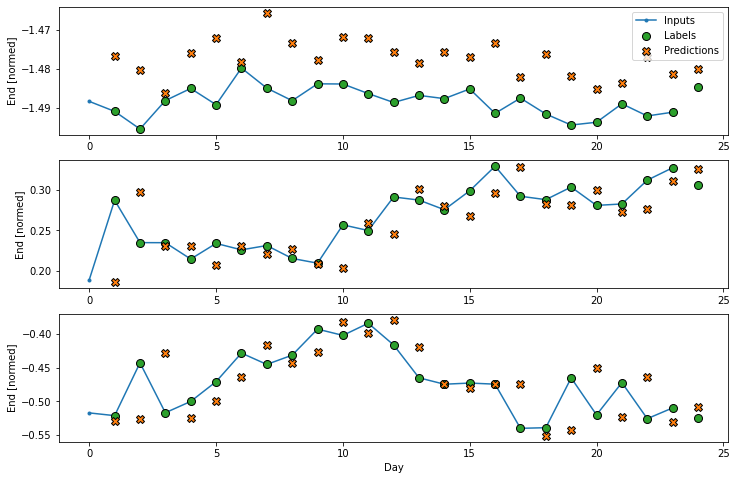

In [ ]:
wide_window.plot(linear)


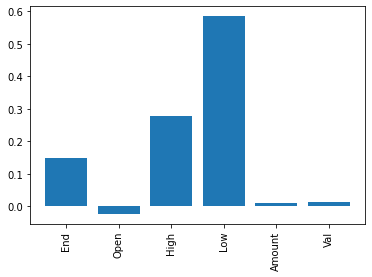

In [ ]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

In [ ]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
228/228 [==============================] - 2s 6ms/step - loss: 0.0505 - mean_absolute_error: 0.1171 - val_loss: 0.0248 - val_mean_absolute_error: 0.1398
Epoch 2/20
228/228 [==============================] - 1s 5ms/step - loss: 0.0215 - mean_absolute_error: 0.0824 - val_loss: 0.0129 - val_mean_absolute_error: 0.0874
Epoch 3/20
228/228 [==============================] - 1s 5ms/step - loss: 0.0213 - mean_absolute_error: 0.0817 - val_loss: 0.0105 - val_mean_absolute_error: 0.0764
Epoch 4/20
228/228 [==============================] - 1s 5ms/step - loss: 0.0210 - mean_absolute_error: 0.0803 - val_loss: 0.0115 - val_mean_absolute_error: 0.0743
Epoch 5/20
65/65 [==============================] - 0s 4ms/step - loss: 0.0168 - mean_absolute_error: 0.1036


Convolution network

In [ ]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['End'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['End']

Text(0.5, 1.0, 'Given 3day as input, predict 1day into the future.')

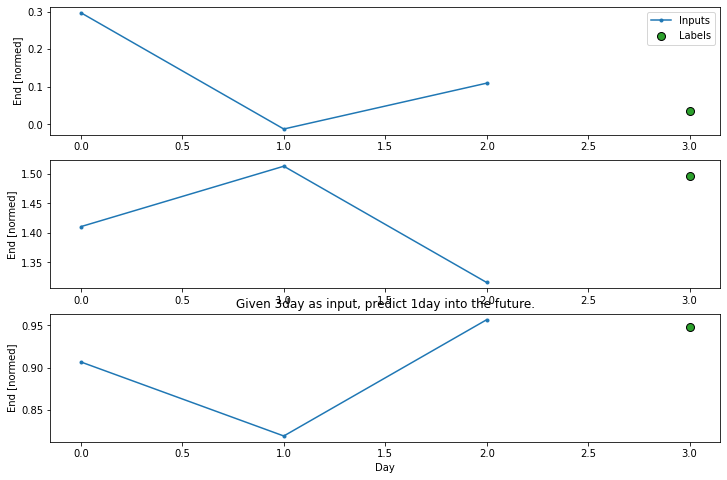

In [ ]:
conv_window.plot()
plt.title("Given 3day as input, predict 1day into the future.")

In [ ]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [ ]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 6)
Output shape: (32, 1, 1)


In [ ]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

65/65 [==============================] - 1s 7ms/step - loss: 0.0071 - mean_absolute_error: 0.0611


In [ ]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 6)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


In [ ]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['End'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['End']

In [ ]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 26, 6)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


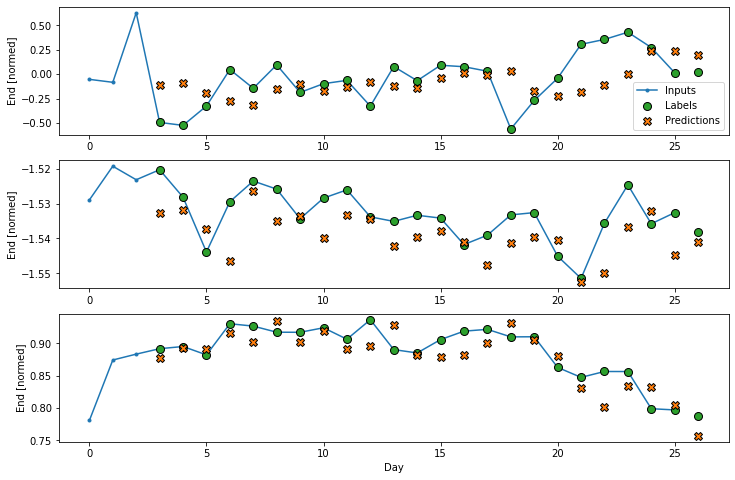

In [ ]:
wide_conv_window.plot(conv_model)

RNN

In [ ]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 6)
Output shape: (32, 24, 1)


In [ ]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

65/65 [==============================] - 0s 5ms/step - loss: 0.1610 - mean_absolute_error: 0.3299


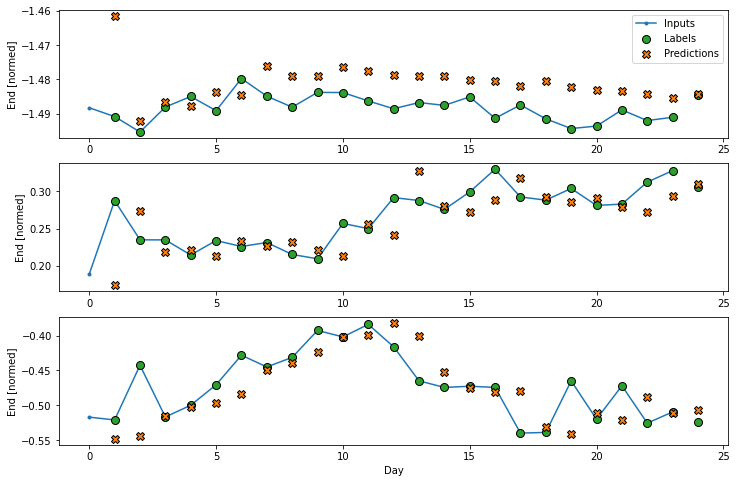

In [ ]:
wide_window.plot(lstm_model)

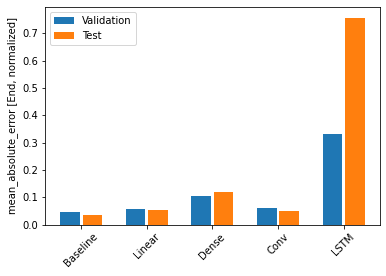

In [ ]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [End, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(), rotation=45)
fig.set_size_inches(20,10)
_ = plt.legend()

In [ ]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.0361
Linear      : 0.0535
Dense       : 0.1207
Conv        : 0.0487
LSTM        : 0.7576
